# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [2]:
# Settings
Username   = 'Beheerder'
years      = range(2001,2022)    #(1997,2021) # Set years to download

In [3]:
import os
datapath   = os.path.join('../../') #since this file is 2 dir down from the data it's ../../
print('datapath is set to %s'%datapath)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
sys.path.append('../') #append the directory above this one to path to be able to find my python modules
import matplotlib.dates as mdates

datapath is set to ../../


## groundwater calculations and write to file

In [113]:
#new location put 88
dir = '../../Dinoloket_2024-01-20/Grondwaterstanden_Put/B32F0088001_1_edit.csv'
df_GWS=pd.read_csv(dir,sep=",",index_col=False)
df_GWS=df_GWS.drop(['Locatie','Filternummer','Bijzonderheid','Opmerking'], axis=1)
#df_GWS['Peildatum']=df_GWS['Peildatum']+" 12:00"
df_GWS['datetime']=pd.to_datetime(df_GWS['Peildatum'], dayfirst=True, format='mixed')
df_GWS.index = df_GWS['datetime']
df_GWS=df_GWS.drop(['Peildatum','datetime'], axis=1)
years_range=(str(list(years)[0])+'-01-01',str(list(years)[-1])+'-12-31')
st=years_range[0]
print(st)
ed=years_range[1]
print(ed)
df_GWS=df_GWS.loc[st:ed,['Stand (cm t.o.v. MV)']]
df_GWS.rename(columns={'Stand (cm t.o.v. MV)':'depth'},inplace=True)

#df_GWS_7d=df_GWS.resample('7D').interpolate()
#avg_GWS_7d = df_GWS_7d['depth'].mean()
#df_GWS_7d['anom']=df_GWS_7d.loc[st:ed,'depth']-avg_GWS_7d
#df_GWS_7d.index=df_GWS_7d.index.astype('datetime64[s]')

2001-01-01
2021-12-31


In [8]:
df_GWS

,depth
datetime,
2001-01-15,109.0
2001-01-29,107.0
2001-02-14,78.0
2001-02-28,84.0
2001-03-14,85.0
...,...
2019-12-27,249.0
2019-12-28,248.0
2019-12-29,247.0


In [6]:
#df_GWS = pd.read_csv('../GWS_daily.csv')
#df_GWS

,datetime,depth,depth_anom_all
0,2001-01-15,109.000000,-82.788726
1,2001-01-16,108.857143,-82.931583
2,2001-01-17,108.714286,-83.074440
3,2001-01-18,108.571429,-83.217298
4,2001-01-19,108.428571,-83.360155
...,...,...,...
6826,2019-12-27,249.000000,57.211274
6827,2019-12-28,248.000000,56.211274
6828,2019-12-29,247.000000,55.211274
6829,2019-12-30,246.000000,54.211274


In [9]:
#up to 18-04-2002 the data is roughly every 14 days. After daily frequency.
df_GWS_daily_2001=df_GWS.loc['2001-01-01':'2002-04-18',['depth']].copy()
#df_GWS_daily_2001.index=df_GWS_daily_2001.index.floor('1D') #if the index has timestamp use this line for .interpolate() to work
df_GWS_daily_2001=df_GWS_daily_2001.resample('1D').interpolate(method='time')
df_GWS_daily_2001=df_GWS_daily_2001.loc[:'2002-04-17'] # remove the date 2002-04-18 for later attachment to rest of dataframe

#create and attach the above interpolated section of df to the rest of the data
df_GWS_daily=pd.DataFrame()
df_GWS_daily=df_GWS.loc['2002-04-18':,['depth']]
#df_GWS_daily.index=df_GWS_daily.index.floor('1D') #need to remove the time
df_GWS_daily=pd.concat([df_GWS_daily_2001,df_GWS_daily],axis=0) #join the two row-wise with concat

avg_GWS_all = df_GWS_daily['depth'].mean()
df_GWS_daily['depth_anom_all'] = df_GWS_daily.loc[st:ed,'depth']-avg_GWS_all

#write data to file

#df_GWS_daily.to_csv('./GWS_daily.csv')

In [10]:
df_GWS_daily

,depth,depth_anom_all
datetime,,
2001-01-15,109.000000,-82.788726
2001-01-16,108.857143,-82.931583
2001-01-17,108.714286,-83.074440
2001-01-18,108.571429,-83.217298
2001-01-19,108.428571,-83.360155
...,...,...
2019-12-27,249.000000,57.211274
2019-12-28,248.000000,56.211274
2019-12-29,247.000000,55.211274


In [11]:
#change since april of that year
#slice up the dataframe into data based on year
#select values between dates of interest (2001-2019)

#create a df that has only the measured values (roughly every 14 days until early 2002)
df_GWS_multi = pd.DataFrame()
df_GWS_multi['yeardate'] = pd.date_range(start="2000-04-01", end="2000-10-30", freq='1D') #using dummy dates for year 2000 because otherwise datetime obj wont work
df_GWS_multi['monthday'] = df_GWS_multi['yeardate'].dt.strftime(date_format='%m-%d')
df_GWS_multi.index=df_GWS_multi['yeardate']

for year in range(2001,2020):
    st=str(year)+'-04-01'
    ed=str(year)+'-10-30'
    df_tmp=df_GWS_daily.loc[st:ed,['depth']]
    df_tmp=df_tmp.rename(columns={'depth':'depth_'+str(year)})
    df_tmp.index=df_tmp.index.strftime(date_format='2000-%m-%d') #set year to 2000 otherwise I can't easily use joins
    df_tmp.index=pd.to_datetime(df_tmp.index)
    #calc difference since april 1
    val_start = df_tmp.loc['2000-04-01','depth_'+str(year)] #the value at april 1st of that year
    df_tmp['depth_'+str(year)+'_diff']=df_tmp['depth_'+str(year)]-val_start #subtract value at april 1st so that it starts at 0
    avg_GWS_season = df_GWS['depth'].mean()
    df_tmp['depth_'+str(year)+'_anom']=df_tmp['depth_'+str(year)]-avg_GWS_season #subtract value at april 1st so that it starts at 0
    #attach temp results to main df
    df_GWS_multi=pd.concat([df_GWS_multi,df_tmp],axis=1)

#from here: https://stackoverflow.com/questions/42138357/pandas-rolling-slope-calculation    
#def calc_slope(x):
#    slope = np.polyfit(range(len(x)), x, 1)[0]
#    return slope

## set min_periods=2 to allow subsets less than 60.
## use [4::5] to select the results you need.
#result = data.rolling(60, min_periods=2).apply(calc_slope)[4::5]
    
#df_GWS_multi

#df_GWS_multi.to_csv('./GWS_multi_daily.csv')

In [12]:
df_GWS_multi

,yeardate,monthday,depth_2001,depth_2001_diff,depth_2001_anom,depth_2002,depth_2002_diff,depth_2002_anom,depth_2003,depth_2003_diff,...,depth_2016_anom,depth_2017,depth_2017_diff,depth_2017_anom,depth_2018,depth_2018_diff,depth_2018_anom,depth_2019,depth_2019_diff,depth_2019_anom
2000-04-01,2000-04-01,04-01,93.160000,0.000000,-104.263859,84.133333,0.000000,-113.290525,124.0,0.0,...,-19.423859,205.0,0.0,7.576141,196.0,0.0,-1.423859,213.0,0.0,15.576141
2000-04-02,2000-04-02,04-02,93.613333,0.453333,-103.810525,84.766667,0.633333,-112.657192,123.0,-1.0,...,-20.423859,206.0,1.0,8.576141,195.0,-1.0,-2.423859,213.0,0.0,15.576141
2000-04-03,2000-04-03,04-03,94.066667,0.906667,-103.357192,85.400000,1.266667,-112.023859,124.0,0.0,...,-20.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,214.0,1.0,16.576141
2000-04-04,2000-04-04,04-04,94.520000,1.360000,-102.903859,86.033333,1.900000,-111.390525,124.0,0.0,...,-19.423859,207.0,2.0,9.576141,193.0,-3.0,-4.423859,214.0,1.0,16.576141
2000-04-05,2000-04-05,04-05,94.973333,1.813333,-102.450525,86.666667,2.533333,-110.757192,123.0,-1.0,...,-18.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,215.0,2.0,17.576141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-26,2000-10-26,10-26,126.142857,32.982857,-71.281002,172.000000,87.866667,-25.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,282.0,69.0,84.576141
2000-10-27,2000-10-27,10-27,126.428571,33.268571,-70.995287,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,293.0,97.0,95.576141,282.0,69.0,84.576141
2000-10-28,2000-10-28,10-28,126.714286,33.554286,-70.709573,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,265.0,60.0,67.576141,294.0,98.0,96.576141,281.0,68.0,83.576141
2000-10-29,2000-10-29,10-29,127.000000,33.840000,-70.423859,166.000000,81.866667,-31.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,281.0,68.0,83.576141


## Groundwater Plots

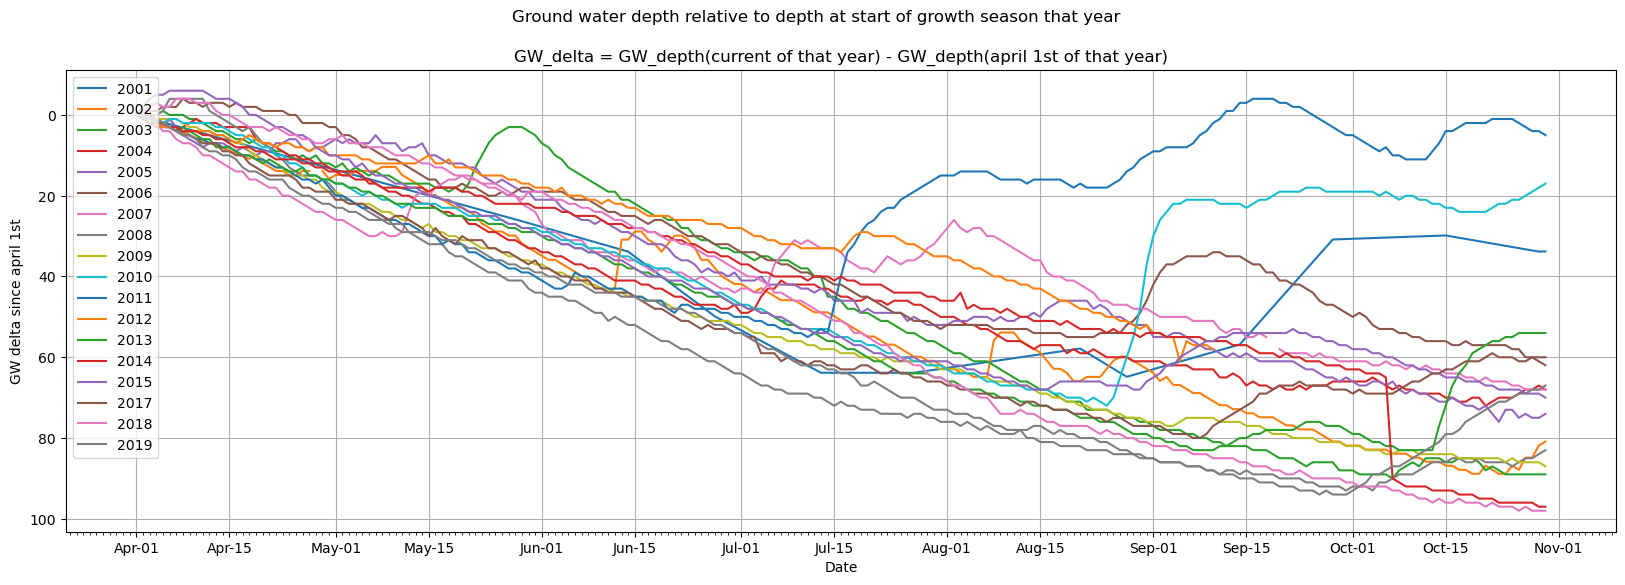

In [9]:
df_GWS_multi # all years

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel('GW delta since april 1st')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)



colored_years={'2003':'green','2006':'orange','2011':'#b62020','2013':'purple','2015':'','2018':'blue'}

for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    if year in colored_years.keys():
        color=colored_years[year]
        marker=''
    else:
        color='grey'
        marker=''
    ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker ,label=year) 
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.grid()

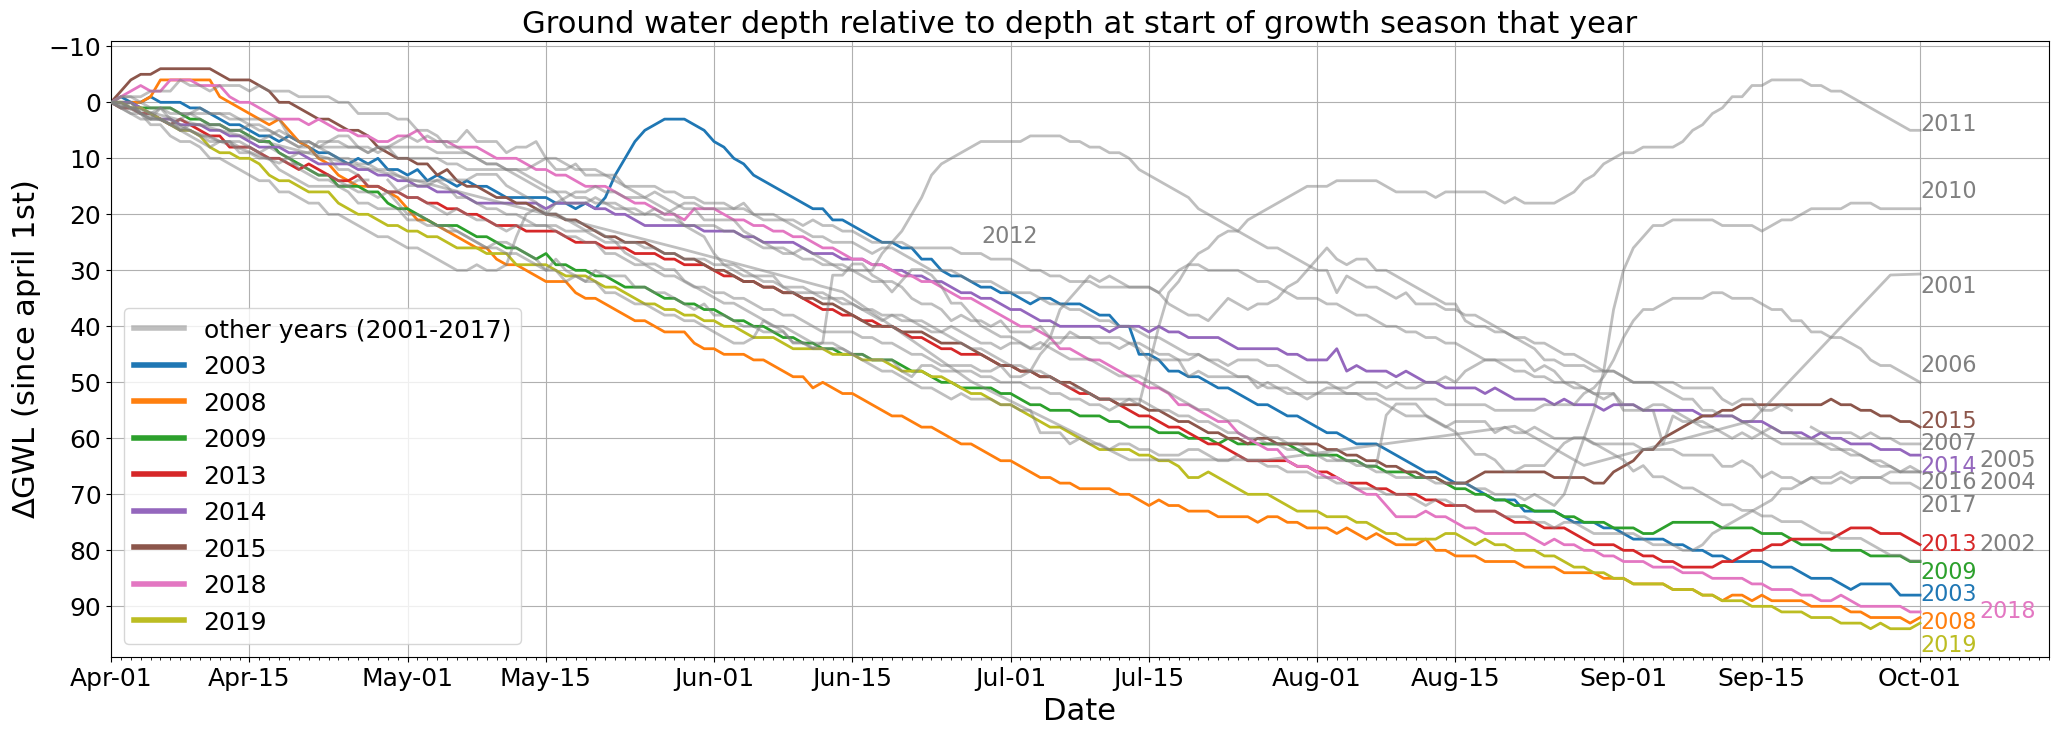

In [189]:
## df_GWS_multi #years that stay down

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams.update({'font.size': 18})

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig,ax = plt.subplots()
ax.set_ylabel(r'$\Delta$GWL (since april 1st)', fontsize=22)
ax.set_xlabel('Date', fontsize=22)

#plt.ylabel(r'$\Delta$GWL (since april 1st)', fontsize=22)
#plt.xlabel('Date', fontsize=22)


#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)

#colored_years={'2003':'green','2008':'orange', 2009'2011':'#b62020','2013':'purple','2018':'blue'}
#2003 2008 2009 2010 (2011) 2013 2014  2018 2019

grey_years=['2002','2004','2005','2006','2007','2010','2011','2012','2016','2017']
special_year='2001' #for legend purposes

#
for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']:
    start='2000-04-01'
    end='2000-10-01'
    marker=''
    lw=2
    if year in grey_years:#colored_years.keys():
        alpha=0.5
        color='grey'
        label='_nolegend_'
        ax.plot(df_GWS_multi.loc[start:end,'yeardate'],df_GWS_multi.loc[start:end,'depth_'+year+'_diff'], linewidth=lw, marker=marker, alpha=alpha, color=color, zorder=3 ,label=label)
    elif year == special_year:
        alpha=0.5
        color='grey'
        label='other years (2001-2017)'
        ax.plot(df_GWS_multi.loc[start:end,'yeardate'],df_GWS_multi.loc[start:end,'depth_'+year+'_diff'], linewidth=lw, marker=marker, alpha=alpha, color=color, zorder=3 ,label=label)
    elif year == '2019': #special case just to make the color of 2019 not dark grey, I could fix it with a custom colormap but I dont have time
        alpha=1.0
        color='#bcbd22'
        label=year
        ax.plot(df_GWS_multi.loc[start:end,'yeardate'],df_GWS_multi.loc[start:end,'depth_'+year+'_diff'], linewidth=lw, marker=marker, color=color, alpha=alpha, zorder=2 ,label=label)
#    elif year == '2016': #special case just to make the color of 2019 not dark grey, I could fix it with a custom colormap but I dont have time
#        alpha=1.0
#        color='#d62728'
#        label=year
#        ax.plot(df_GWS_multi.loc[start:end,'yeardate'],df_GWS_multi.loc[start:end,'depth_'+year+'_diff'], marker=marker, color=color, alpha=alpha, zorder=2 ,label=label)
    else:
        alpha=1.0
        label=year
        ax.plot(df_GWS_multi.loc[start:end,'yeardate'],df_GWS_multi.loc[start:end,'depth_'+year+'_diff'], linewidth=lw, marker=marker, alpha=alpha, zorder=2 ,label=label)

ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.set_xlim(df_GWS_multi.index[0],pd.to_datetime('2000-10-14'))

fz=16

ax.text(pd.to_datetime('2000-10-07'),92,'2018',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][6],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),66,'2014',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][4],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),89,'2003',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),85,'2009',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),94,'2008',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),98,'2019',c='#bcbd22',fontsize=fz) #special case, this is default cmap color with index=8, skipping index 7 as its a dark grey 
ax.text(pd.to_datetime('2000-10-01'),80,'2013',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3],fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),58,'2015',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][5],fontsize=fz)
#grey years
ax.text(pd.to_datetime('2000-10-01'),34,'2001',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-07'),80,'2002',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-07'),69,'2004',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),62,'2007',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-07'),65,'2005',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),69,'2016',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),17,'2010',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),5,'2011',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-06-28'),25,'2012',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),73,'2017',c='grey',fontsize=fz)
ax.text(pd.to_datetime('2000-10-01'),48,'2006',c='grey',fontsize=fz)


#fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('Ground water depth relative to depth at start of growth season that year', fontsize=22 )
#ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
leg = ax.legend(loc=("lower left"))

for line in leg.get_lines():
    line.set_linewidth(4.0)

ax.grid()

#### unifinished, unused timeseries till 1 nov

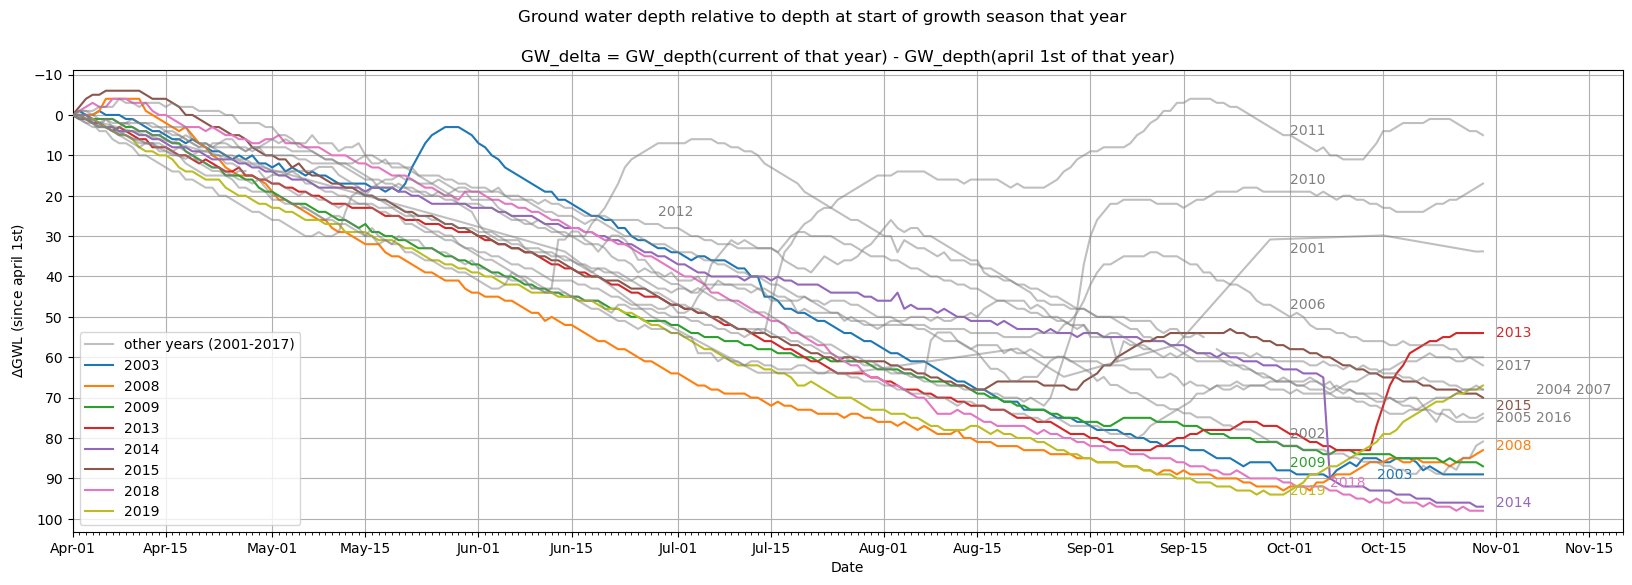

In [129]:
## df_GWS_multi #years that stay down

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel(r'$\Delta$GWL (since april 1st)')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)

#colored_years={'2003':'green','2008':'orange', 2009'2011':'#b62020','2013':'purple','2018':'blue'}
#2003 2008 2009 2010 (2011) 2013 2014  2018 2019

grey_years=['2002','2004','2005','2006','2007','2010','2011','2012','2016','2017']
special_year='2001' #for legend purposes

#
for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    marker=''
    if year in grey_years:#colored_years.keys():
        alpha=0.5
        color='grey'
        label='_nolegend_'
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, alpha=alpha, color=color, zorder=3 ,label=label)
    elif year == special_year:
        alpha=0.5
        color='grey'
        label='other years (2001-2017)'
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, alpha=alpha, color=color, zorder=3 ,label=label)
    elif year == '2019': #special case just to make the color of 2019 not dark grey, I could fix it with a custom colormap but I dont have time
        alpha=1.0
        color='#bcbd22'
        label=year
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, color=color, alpha=alpha, zorder=2 ,label=label)
    else:
        alpha=1.0
        label=year
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, alpha=alpha, zorder=2 ,label=label)
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.set_xlim(df_GWS_multi.index[0],pd.to_datetime('2000-11-20'))

ax.text(pd.to_datetime('2000-10-07'),92,'2018',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][6])
ax.text(pd.to_datetime('2000-11-01'),97,'2014',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][4])
ax.text(pd.to_datetime('2000-10-14'),90,'2003',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax.text(pd.to_datetime('2000-10-01'),87,'2009',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
ax.text(pd.to_datetime('2000-11-01'),83,'2008',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax.text(pd.to_datetime('2000-10-01'),94,'2019',c='#bcbd22') #special case, this is default cmap color with index=8, skipping index 7 as its a dark grey 
ax.text(pd.to_datetime('2000-11-01'),55,'2013',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
ax.text(pd.to_datetime('2000-11-01'),73,'2015',c=plt.rcParams['axes.prop_cycle'].by_key()['color'][5])
#grey years
ax.text(pd.to_datetime('2000-10-01'),34,'2001',c='grey')
ax.text(pd.to_datetime('2000-10-01'),80,'2002',c='grey')
ax.text(pd.to_datetime('2000-11-07'),69,'2004',c='grey')
ax.text(pd.to_datetime('2000-11-13'),69,'2007',c='grey')
ax.text(pd.to_datetime('2000-11-01'),76,'2005',c='grey')
ax.text(pd.to_datetime('2000-11-07'),76,'2016',c='grey')
ax.text(pd.to_datetime('2000-10-01'),17,'2010',c='grey')
ax.text(pd.to_datetime('2000-10-01'),5,'2011',c='grey')
ax.text(pd.to_datetime('2000-06-28'),25,'2012',c='grey')
ax.text(pd.to_datetime('2000-11-01'),63,'2017',c='grey')
ax.text(pd.to_datetime('2000-10-01'),48,'2006',c='grey')


fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.legend(loc=("lower left"))
ax.grid()

#### end of unifinished, unused timeseries till 1 nov

In [39]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# all years GWS

In [27]:
df_GWS_multi.loc['2001'+'']

,yeardate,monthday,depth_2001,depth_2001_diff,depth_2001_anom,depth_2002,depth_2002_diff,depth_2002_anom,depth_2003,depth_2003_diff,...,depth_2016_anom,depth_2017,depth_2017_diff,depth_2017_anom,depth_2018,depth_2018_diff,depth_2018_anom,depth_2019,depth_2019_diff,depth_2019_anom
2000-04-01,2000-04-01,04-01,93.160000,0.000000,-104.263859,84.133333,0.000000,-113.290525,124.0,0.0,...,-19.423859,205.0,0.0,7.576141,196.0,0.0,-1.423859,213.0,0.0,15.576141
2000-04-02,2000-04-02,04-02,93.613333,0.453333,-103.810525,84.766667,0.633333,-112.657192,123.0,-1.0,...,-20.423859,206.0,1.0,8.576141,195.0,-1.0,-2.423859,213.0,0.0,15.576141
2000-04-03,2000-04-03,04-03,94.066667,0.906667,-103.357192,85.400000,1.266667,-112.023859,124.0,0.0,...,-20.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,214.0,1.0,16.576141
2000-04-04,2000-04-04,04-04,94.520000,1.360000,-102.903859,86.033333,1.900000,-111.390525,124.0,0.0,...,-19.423859,207.0,2.0,9.576141,193.0,-3.0,-4.423859,214.0,1.0,16.576141
2000-04-05,2000-04-05,04-05,94.973333,1.813333,-102.450525,86.666667,2.533333,-110.757192,123.0,-1.0,...,-18.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,215.0,2.0,17.576141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-26,2000-10-26,10-26,126.142857,32.982857,-71.281002,172.000000,87.866667,-25.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,282.0,69.0,84.576141
2000-10-27,2000-10-27,10-27,126.428571,33.268571,-70.995287,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,293.0,97.0,95.576141,282.0,69.0,84.576141
2000-10-28,2000-10-28,10-28,126.714286,33.554286,-70.709573,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,265.0,60.0,67.576141,294.0,98.0,96.576141,281.0,68.0,83.576141
2000-10-29,2000-10-29,10-29,127.000000,33.840000,-70.423859,166.000000,81.866667,-31.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,281.0,68.0,83.576141


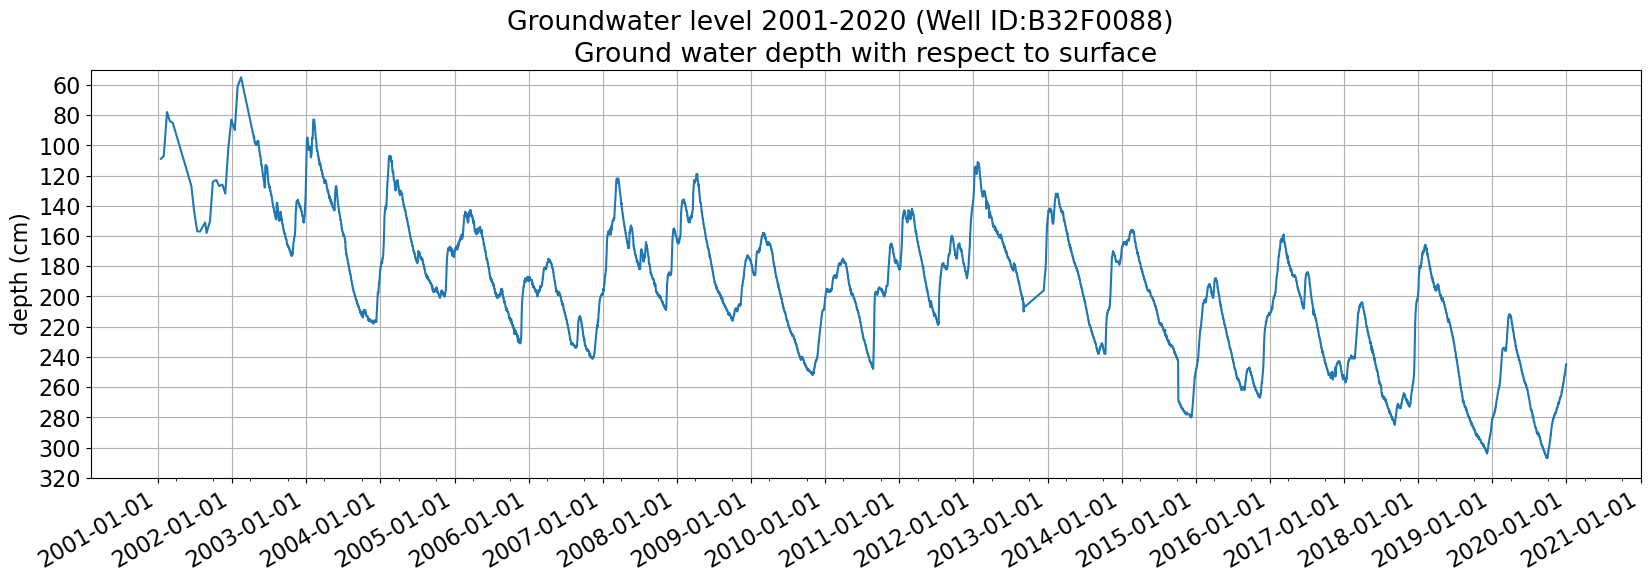

In [5]:
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FixedLocator
#from matplotlib.axis import Axis
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,6)
fig, ax1 =plt.subplots(nrows=1,ncols=1)

ax1.plot(df_GWS['depth'])

ax1.set_ylim(50,320)
ax1.set_title('Ground water depth with respect to surface')
ax1.set_ylabel('depth (cm)')

ax1.invert_yaxis()
fig.suptitle('Groundwater level 2001-2020 (Well ID:B32F0088)')
years = [datetime(year,1,1) for year in range(2001,2022)]
f1=lambda year: datetime(year,4,1)
f2=lambda year: datetime(year,10,1)
growseasons = [f(year) for year in range(2001,2021) for f in (f1,f2)] #double list comprehension pattern: [f(x) for x in range(5) for f in (f1,f2)]
xticks = [mdates.date2num(z) for z in growseasons]
#Axis.set_major_locator(ax1.xaxis, years)
ax1.yaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.FixedLocator(xticks))
#ax1.yaxis.set_minor_locator(growseasons)
ax1.xaxis.set_ticks(years)
fig.autofmt_xdate() #allows you to auto-align the x axis labels
ax1.grid()
#ax1.grid(axis='x', which='major')

#print(growseasons)

plt.show()